# Data Preprocessing and Cleaning

In [1]:
import pandas as pd

In [2]:
# Load dataset and preview data structure
df= pd.read_csv("C:\\Users\\olale\\Downloads\\fashion_reviews_cleaned.csv")

In [3]:
#check data types
# Dataset contains ~2.5 million fashion reviews with rating, text, and product metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500939 entries, 0 to 2500938
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   rating             float64
 1   text               object 
 2   asin               object 
 3   user_id            object 
 4   timestamp          int64  
 5   helpful_vote       int64  
 6   verified_purchase  bool   
 7   main_category      object 
 8   review_date        object 
dtypes: bool(1), float64(1), int64(2), object(5)
memory usage: 155.0+ MB


In [4]:
#check for missing values
df.isnull().sum()

rating                  0
text                 1094
asin                    0
user_id                 0
timestamp               0
helpful_vote            0
verified_purchase       0
main_category           0
review_date             0
dtype: int64

In [5]:
# Drop rows with missing review text to ensure consistent sentiment analysis
df= df.dropna(subset=['text'])

In [6]:
df.isnull().sum()

rating               0
text                 0
asin                 0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
main_category        0
review_date          0
dtype: int64

In [7]:
# Convert review date to datetime format for lifecycle modeling
df['review_date'] = pd.to_datetime(df['review_date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2499845 entries, 0 to 2500938
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   rating             float64       
 1   text               object        
 2   asin               object        
 3   user_id            object        
 4   timestamp          int64         
 5   helpful_vote       int64         
 6   verified_purchase  bool          
 7   main_category      object        
 8   review_date        datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 174.0+ MB


In [9]:
df['review_date'].head()

0   2020-01-09 00:06:34.489
1   2020-12-20 01:04:06.701
2   2015-05-23 01:33:48.000
3   2018-12-31 20:57:27.095
4   2015-08-13 14:29:26.000
Name: review_date, dtype: datetime64[ns]

# Temporal Structuring & Lifecycle Modeling

In [10]:
# Sort reviews chronologically by product ID and timestamp
# Group by month to track review volume trends over time
df= df.sort_values(by=['asin', 'review_date'])
review_counts = df.groupby(['asin', pd.Grouper(key='review_date', freq='ME')])['rating'].count().reset_index()

### Extract product launch date using first review timestamp
### Calculate days since launch for each review
### Classify reviews into product lifecycle stages (Launch, Growth, Mature, Decline)

In [11]:
# Get launch date per product
launch_dates = df.groupby('asin')['review_date'].min().rename('launch_date')
df = df.merge(launch_dates, on ='asin')

In [12]:
#calculate days since launch
df['days_since_launch'] = (df['review_date']-df['launch_date']).dt.days

In [13]:
#Tag lifecycle stage
df['lifecycle_stage']=pd.cut(
    df['days_since_launch'],
    bins=[-1, 30, 90, 180, 10000],
    labels=['Launch', 'Growth', 'Mature', 'Decline']
)

In [14]:
df.head()

,rating,text,asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,review_date,launch_date,days_since_launch,lifecycle_stage
0,5.0,"I'm 6'1"" and usually get xl but at this price ...",0000099813,AF4X5EEPQF23KFIEWWJWFBR4J3TQ,1573785465165,0,True,AMAZON FASHION,2019-11-15 02:37:45.165,2019-11-15 02:37:45.165,0,Launch
1,5.0,I jeep with Doors & top off in 30 & below weat...,0000099813,AH2JIO7552XIPHTNRXLG73NHGXEA,1577880862504,0,True,AMAZON FASHION,2020-01-01 12:14:22.504,2019-11-15 02:37:45.165,47,Growth
2,5.0,I bought elsewhere before I saw them here. The...,0000099813,AGNTVEUIXCLPEI7TOFQURTRT264A,1580183810473,0,False,AMAZON FASHION,2020-01-28 03:56:50.473,2019-11-15 02:37:45.165,74,Growth
3,5.0,I carry my bible and I le accessories in this...,0310807115,AFL2SICKO2EBKUJBDB5SXQHCG5HQ,1352609059000,0,True,AMAZON FASHION,2012-11-11 04:44:19.000,2012-11-11 04:44:19.000,0,Launch
4,5.0,Me encantó y quedó mi talla.,0512238944,AH4YEZV2KLY4ANWX6ULQGQC264NA,1652874872495,0,True,AMAZON FASHION,2022-05-18 11:54:32.495,2022-05-18 11:54:32.495,0,Launch


# Text Processing and sentiment scoring

### Clean review text: lowercase, remove punctuation, normalize spacing
### Score baseline sentiment polarity using TextBlob
### Label sentiment as Positive, Neutral, or Negative based on polarity thresholds


In [15]:
import re

def clean_text(text):
    text = str(text).lower() 
    text = re.sub(r'[^a-z\s]', '', text) #remove puntuation and special character
    text = re.sub(r'\s+', ' ', text).strip() # Normalize white spaces
    return text
    

In [16]:
df['clean_text'] = df['text'].apply(clean_text)

In [17]:
# BAseline Sentiment Scoring
from textblob import TextBlob
df['sentiment_score'] =df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [18]:
def label_sentiment(score):
    if score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'
df['sentiment_label']=df['sentiment_score'].apply(label_sentiment)

# Aspect Basic Tagging

### Define keyword sets for core aspects: fit, quality, delivery, price
### Tag each review based on keyword matches
### Default to 'general' if no aspect keyword is found

In [19]:
# Basic Aspect tagging
aspects = {
    "fit": ["fit", "size", "tight", "loose", "snug"],
    "quality": ["quality", "material", "fabric", "stitch", "durable"],
    "delivery": ["delivery", "shipping", "arrived", "late", "fast"],
    "price": ["price", "cost", "expensive", "cheap", "value"]
}

In [20]:
def find_aspects(text):
    aspect_hits= []
    for aspect, keywords in aspects.items():
        if any (word in text for word in keywords):
            aspect_hits.append(aspect)
    return aspect_hits if aspect_hits else ['general']

df['aspects'] = df['clean_text']. apply(find_aspects)

# Feature  engineering

### Encode lifecycle stage as numeric feature
### Binarize aspect tags into separate columns: fit, quality, delivery, price, general
### Scale sentiment scores for model readiness
### Create review length feature based on word count
### Encode main category as numeric feature

In [21]:
# Feature  engineering
# Encode categorical features

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['lifecycle_code'] = le.fit_transform(df['lifecycle_stage'])

In [22]:
# Encode aspect tags: Tagging each aspect as a binary feature

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
aspect_encoded = mlb.fit_transform(df['aspects'])
aspect_df = pd.DataFrame(aspect_encoded, columns=mlb.classes_)
df =pd.concat([df, aspect_df], axis=1)

In [23]:
# scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['scaled_sentiment'] = scaler.fit_transform(df[['sentiment_score']])

In [24]:
# Create review length feature based on word count
df["review_length"] = df["clean_text"].apply(lambda x: len(x.split()))

In [25]:
# Encode main category as numeric feature
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["main_category_code"] = le.fit_transform(df["main_category"])

# Model building and Evaluation
### Check for rating class imbalance using value counts and bar plot

### Apply stratified sampling to preserve rating distribution in train/test split

### Train Random Forest Regressor on engineered features to predict customer ratings

### Evaluate model using MAE and RMSE for performance assessment

In [26]:
#Define target and feature set
features = [
    "sentiment_score",
    "review_length",           
    "lifecycle_code",          
    "main_category_code",          
    "verified_purchase",       
    "helpful_vote",            
    "scaled_sentiment",        
    # Aspect flags
    "fit", "quality", "delivery", "price", "general"
]
target = "rating"

<Axes: xlabel='rating'>

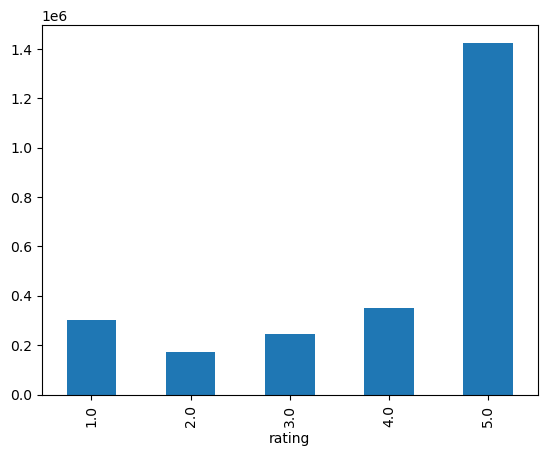

In [27]:
#check for class balance

df[target]. value_counts().sort_index().plot(kind='bar')

In [28]:
df[target]. value_counts()

rating
5.0    1425489
4.0     352153
1.0     303343
3.0     245422
2.0     173438
Name: count, dtype: int64

In [29]:
# Use stratified sampling to ensure each ratimg class is proportionally represented

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df['rating']):
    train_set = df.loc[train_idx]
    test_set = df.loc[test_idx]

x_train = train_set[features]
y_train = train_set['rating']

x_test = test_set[features]
y_test = test_set['rating']

In [30]:
print(df.columns.tolist())


['rating', 'text', 'asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'main_category', 'review_date', 'launch_date', 'days_since_launch', 'lifecycle_stage', 'clean_text', 'sentiment_score', 'sentiment_label', 'aspects', 'lifecycle_code', 'delivery', 'fit', 'general', 'price', 'quality', 'scaled_sentiment', 'review_length', 'main_category_code']


In [31]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)


RandomForestRegressor(random_state=42)

In [32]:
y_pred = model.predict(x_test)

In [33]:
import os
os.makedirs("plots", exist_ok = True)

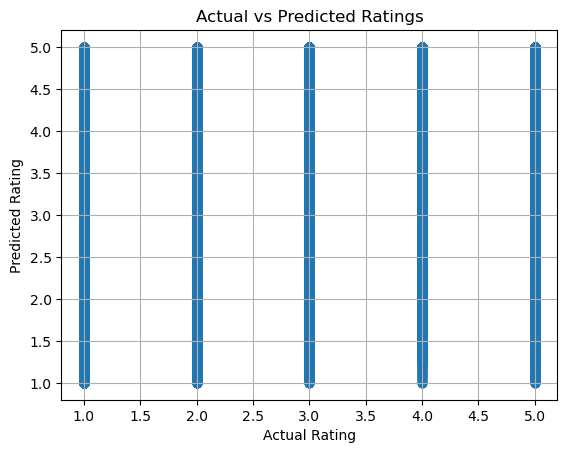

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs Predicted Ratings")
plt.grid(True)
plt.savefig("plots/actual_vs_predicted.png", bbox_inches="tight")
plt.show()


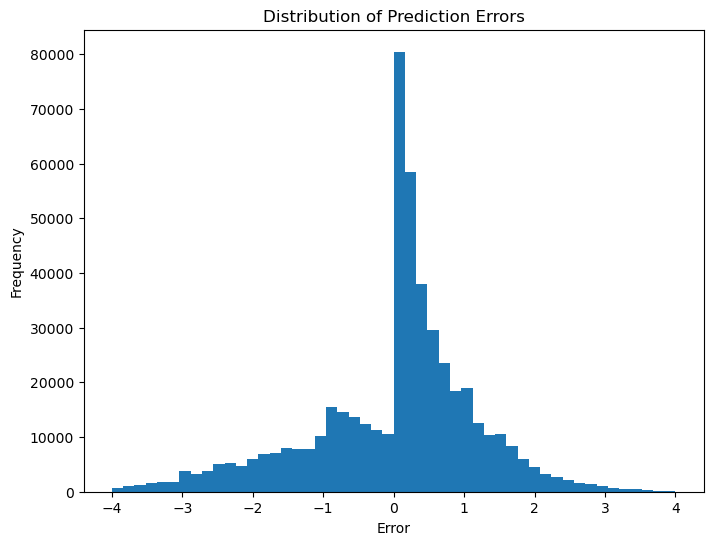

In [36]:
#residual plot to show prediction errors
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.savefig("plots/error_distribution.png", bbox_inches="tight")
plt.show()


In [37]:
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse= mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 0.87
RMSE: 1.19


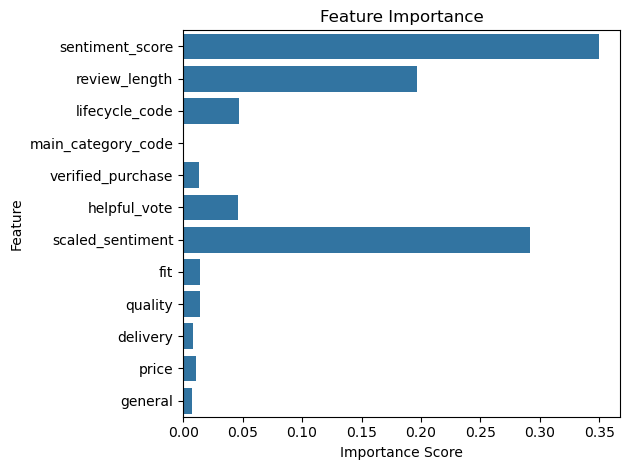

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

importances =pd.Series(model.feature_importances_, index =features)
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")

plt.tight_layout()
plt.savefig("plots/feature_importance.png", bbox_inches="tight")
plt.show()


# Summary and Next Steps
This notebook models customer ratings from fashion reviews using sentiment polarity, aspect tags, and lifecycle features. While performance is solid (MAE ~0.87), future work will explore ordinal regression techniques and deeper aspect-sentiment interactions.

Next steps include:
- Model interpretation using SHAP
- Lifecycle-aware feature tuning
- Deployment of model insights into a dashboard or business strategy context